In [2]:
import os

import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as pl
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import talib


In [23]:

# Define file paths for the datasets
file_paths = [
    "C:\\Users\\Hasan\\Desktop\\data science folder\\AAPL_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\AMZN_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\GOOG_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\META_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\MSFT_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\NVDA_historical_data.csv",
    "C:\\Users\\Hasan\\Desktop\\data science folder\\TSLA_historical_data.csv"
]

stock_names = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Load datasets and add a 'Stock' column
dataframes = []
for file, stock in zip(file_paths, stock_names):
    df = pd.read_csv(file)
    df['Stock'] = stock  # Add stock name to differentiate
    dataframes.append(df)

# Combine all datasets into a single DataFrame
combined_data = pd.concat(dataframes, ignore_index=True)

# Display basic information
print(combined_data.head())


         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits Stock  
0        0.0           0.0  AAPL  
1        0.0           0.0  AAPL  
2        0.0           0.0  AAPL  
3        0.0           0.0  AAPL  
4        0.0           0.0  AAPL  


In [26]:
# Convert 'Date' column to datetime and sort data by Stock and Date
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.sort_values(by=['Stock', 'Date'], inplace=True)

# Function to calculate financial metrics
def calculate_metrics(df):
    df['Daily_Return'] = df['Close'].pct_change()  # Daily returns
    df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod()  # Cumulative returns
    df['20_MA'] = df['Close'].rolling(window=20).mean()  # 20-day moving average
    df['50_MA'] = df['Close'].rolling(window=50).mean()  # 50-day moving average
    return df

# Apply metrics calculation to each stock
analyzed_data = combined_data.groupby('Stock', group_keys=False).apply(calculate_metrics)

# Save the analyzed data to a CSV file
output_path = "C:\\Users\\Hasan\\Desktop\\data science folder\\analyzed_financial_data.csv"
analyzed_data.to_csv(output_path, index=False)
print(f"Analyzed data saved to {output_path}")


C:\Users\Hasan\AppData\Local\Temp\ipykernel_15020\3689649498.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analyzed_data = combined_data.groupby('Stock', group_keys=False).apply(calculate_metrics)


Analyzed data saved to C:\Users\Hasan\Desktop\data science folder\analyzed_financial_data.csv


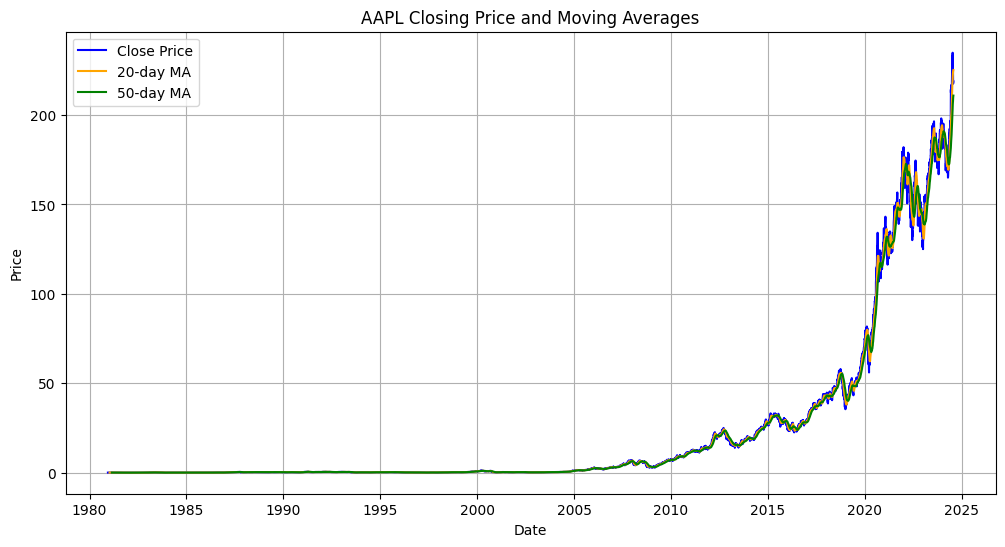

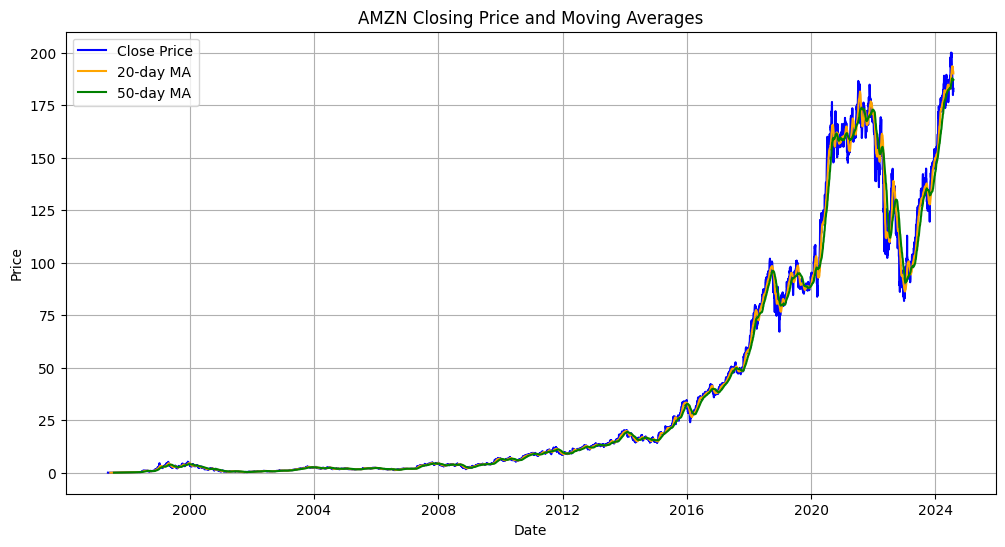

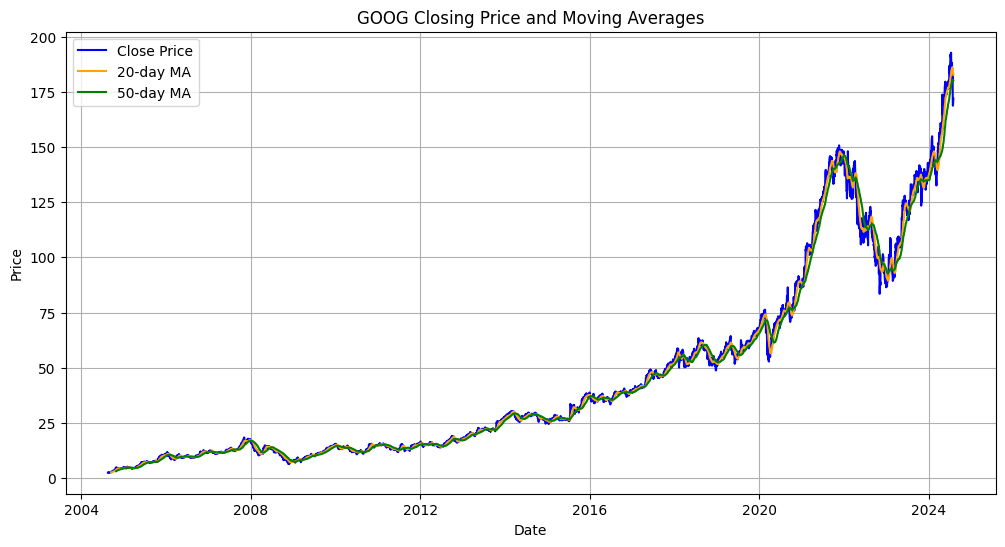

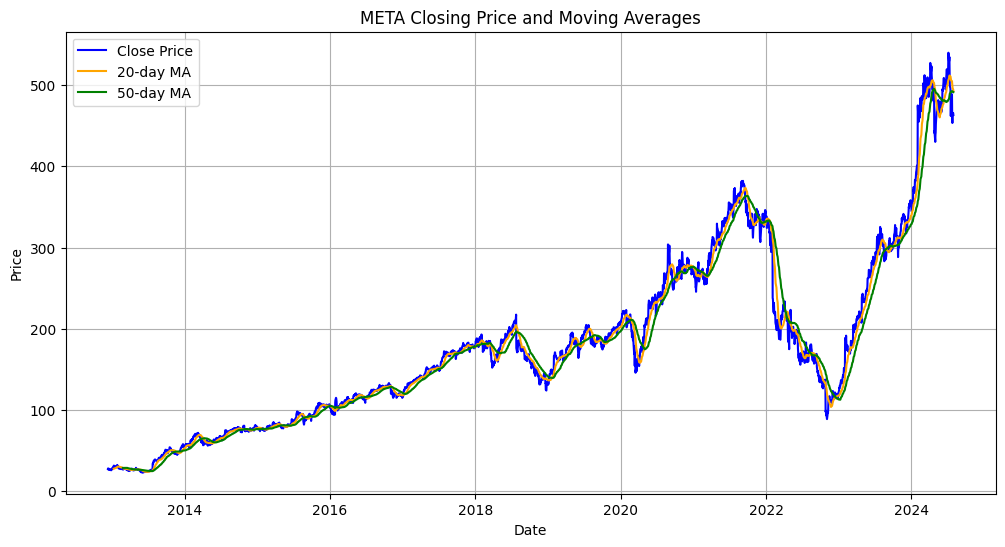

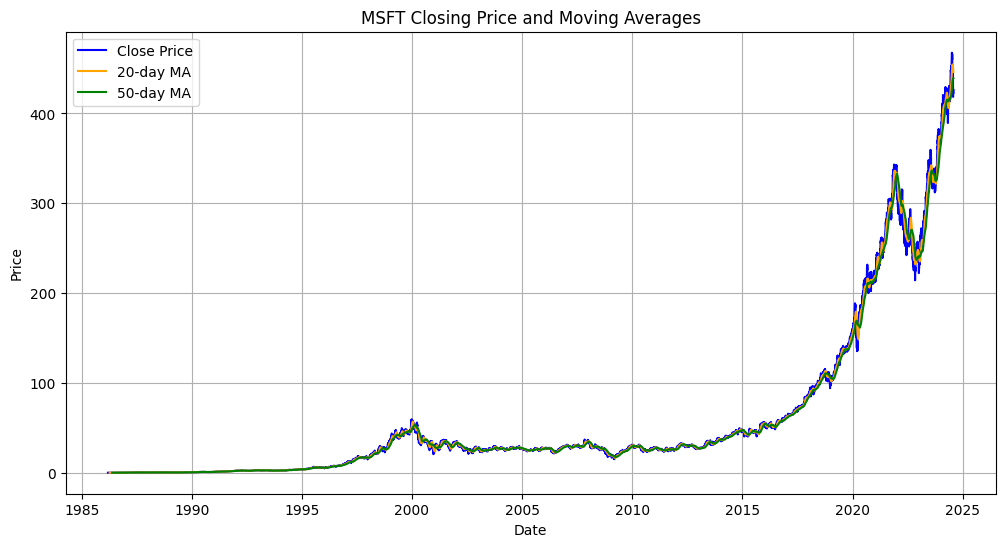

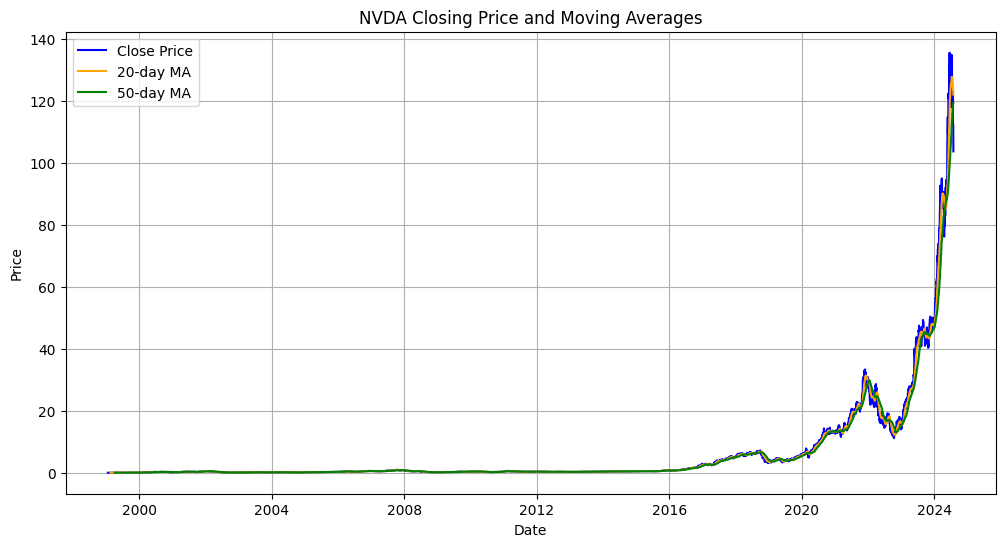

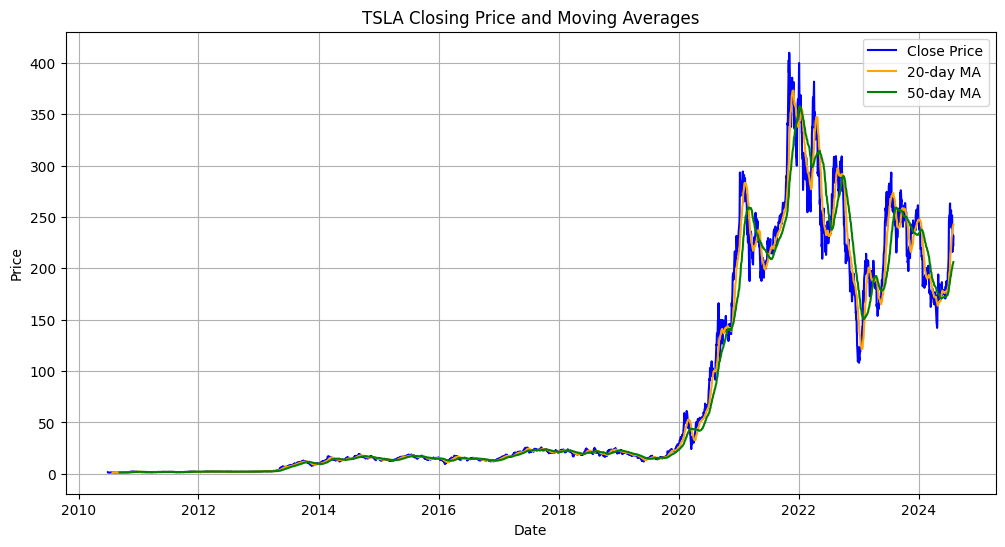

      Daily_Return           Cumulative_Return
              mean       std              last
Stock                                         
AAPL      0.001073  0.027895       1704.740356
AMZN      0.001716  0.035429       1855.755492
GOOG      0.001029  0.019318         68.767846
META      0.001260  0.024277         16.794416
MSFT      0.001091  0.021126       4350.044351
NVDA      0.001933  0.037865       2529.013073
TSLA      0.002035  0.035871        139.778119


In [30]:
# Visualization: Function to plot data for a specific stock
def plot_stock(stock):
    stock_data = analyzed_data[analyzed_data['Stock'] == stock]
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
    plt.plot(stock_data['Date'], stock_data['20_MA'], label='20-day MA', color='orange')
    plt.plot(stock_data['Date'], stock_data['50_MA'], label='50-day MA', color='green')
    plt.title(f'{stock} Closing Price and Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()
    # Generate plots for each stock
for stock in stock_names:
    plot_stock(stock)

# Print summary statistics
summary_stats = analyzed_data.groupby('Stock').agg({
    'Daily_Return': ['mean', 'std'],
    'Cumulative_Return': 'last'
})
print(summary_stats)